# We divide modelling into 2 parts - first is modelling the scale, the second is modelling the hourly profile
## in this notebook i focus on scale - expressed as a target value equal to traffic in peak hours
## i calculate the target, explore which variables are important in prediction of this factor

In [2]:
import pandas as pd
df_all = pd.read_parquet("../merged_dfs/df_all.parquet")

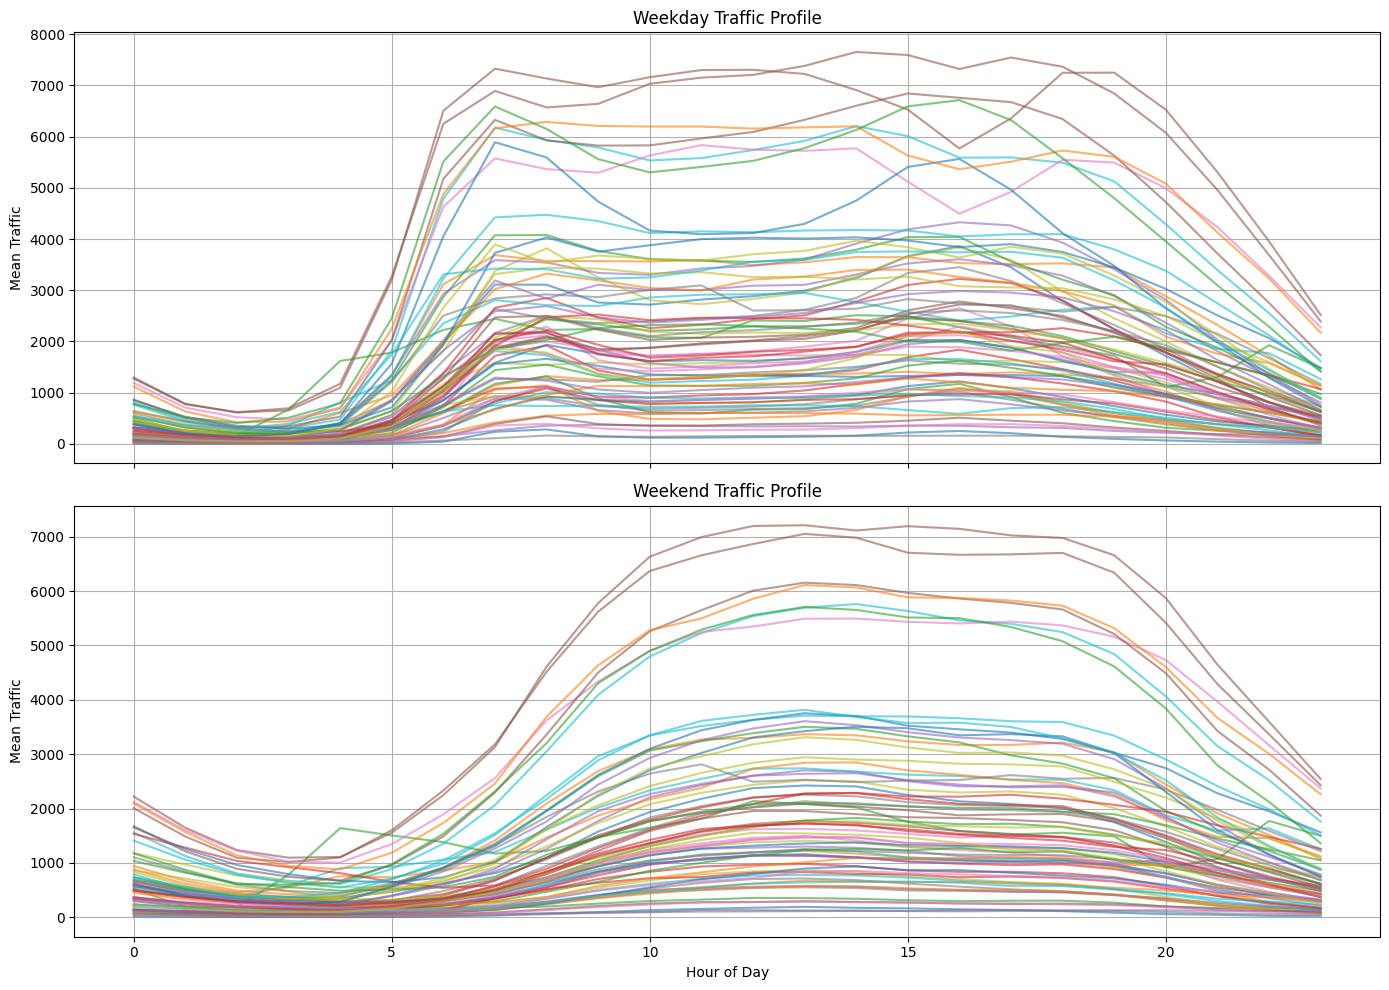

In [3]:
# traffic profile
import matplotlib.pyplot as plt

df_all["dayofweek"] = pd.to_datetime(df_all["date"]).dt.dayofweek  # Monday = 0, Sunday = 6
df_all["is_weekend"] = df_all["dayofweek"] >= 5  # Saturday=5, Sunday=6
grouped_weekday = df_all[df_all["is_weekend"] == False].groupby(["h3res13", "hour"])["traffic"].mean().reset_index()
grouped_weekend = df_all[df_all["is_weekend"] == True].groupby(["h3res13", "hour"])["traffic"].mean().reset_index()


# Create vertically stacked plots
fig, axes = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

# Weekday plot
for h3_id in grouped_weekday["h3res13"].unique():
    subset = grouped_weekday[grouped_weekday["h3res13"] == h3_id]
    axes[0].plot(subset["hour"], subset["traffic"], alpha=0.6, label=str(h3_id))
axes[0].set_title("Weekday Traffic Profile")
axes[0].set_ylabel("Mean Traffic")
axes[0].grid(True)

# Weekend plot
for h3_id in grouped_weekend["h3res13"].unique():
    subset = grouped_weekend[grouped_weekend["h3res13"] == h3_id]
    axes[1].plot(subset["hour"], subset["traffic"], alpha=0.6, label=str(h3_id))
axes[1].set_title("Weekend Traffic Profile")
axes[1].set_xlabel("Hour of Day")
axes[1].set_ylabel("Mean Traffic")
axes[1].grid(True)

plt.tight_layout()
plt.show()


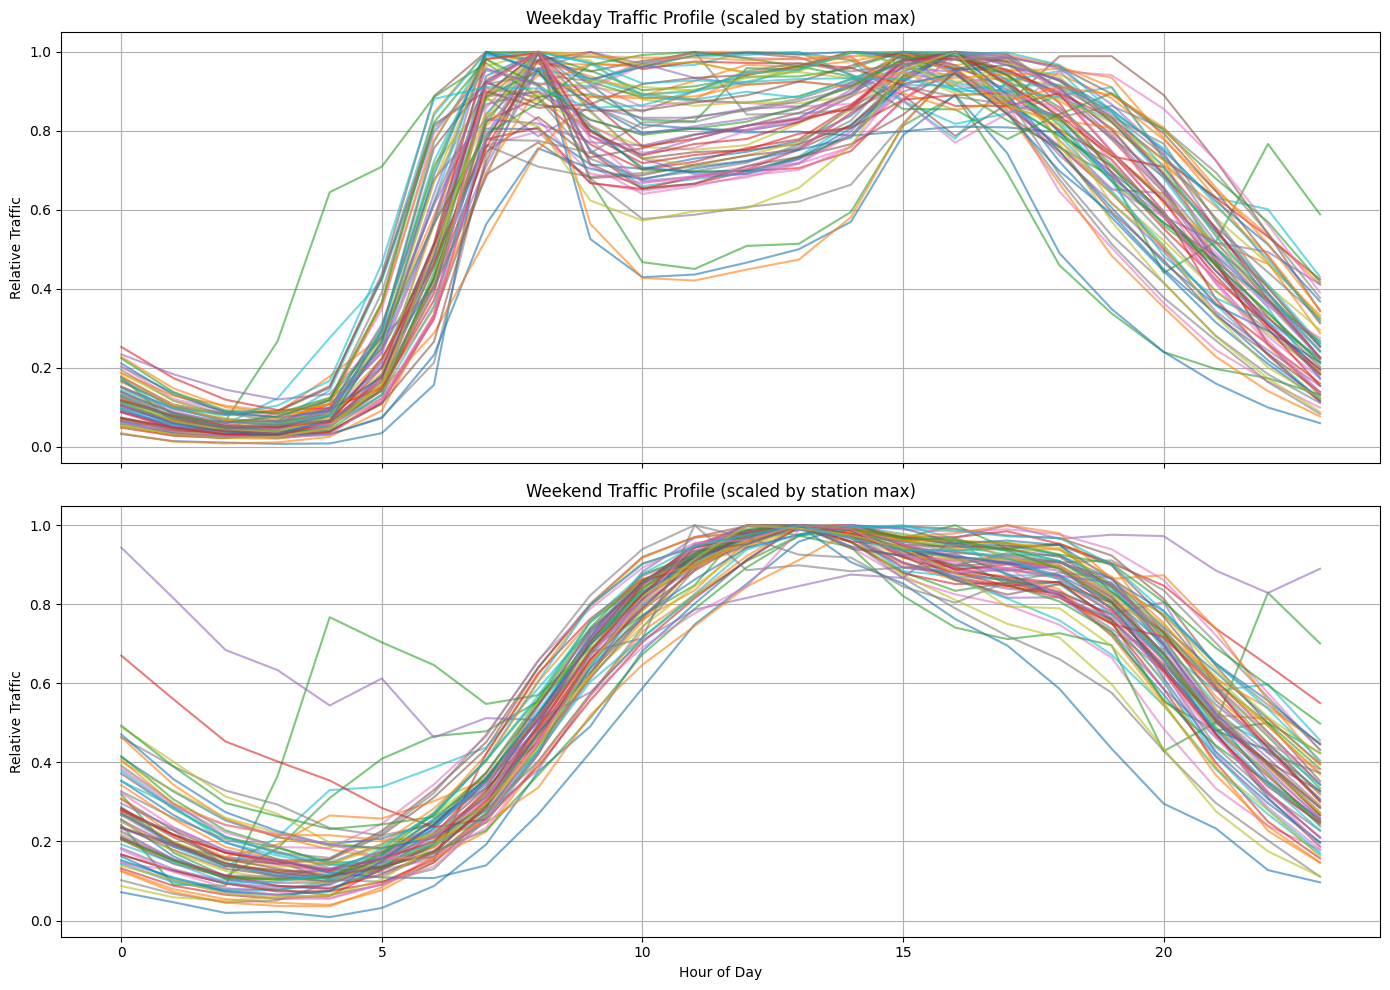

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

# Convert date and add weekend indicator
df_all["dayofweek"] = pd.to_datetime(df_all["date"]).dt.dayofweek  # Monday = 0, Sunday = 6
df_all["is_weekend"] = df_all["dayofweek"] >= 5  # Saturday & Sunday

# Group and calculate mean traffic per hour per station
grouped_weekday = df_all[df_all["is_weekend"] == False].groupby(["h3res13", "hour"])["traffic"].mean().reset_index()
grouped_weekend = df_all[df_all["is_weekend"] == True].groupby(["h3res13", "hour"])["traffic"].mean().reset_index()

# Normalize traffic by mean per station (to compare relative patterns)
grouped_weekday["traffic_rel"] = grouped_weekday.groupby("h3res13")["traffic"].transform(lambda x: x / x.max())
grouped_weekend["traffic_rel"] = grouped_weekend.groupby("h3res13")["traffic"].transform(lambda x: x / x.max())

# Create vertically stacked plots
fig, axes = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

# Weekday plot
for h3_id in grouped_weekday["h3res13"].unique():
    subset = grouped_weekday[grouped_weekday["h3res13"] == h3_id]
    axes[0].plot(subset["hour"], subset["traffic_rel"], alpha=0.6, label=str(h3_id))
axes[0].set_title("Weekday Traffic Profile (scaled by station max)")
axes[0].set_ylabel("Relative Traffic")
axes[0].grid(True)

# Weekend plot
for h3_id in grouped_weekend["h3res13"].unique():
    subset = grouped_weekend[grouped_weekend["h3res13"] == h3_id]
    axes[1].plot(subset["hour"], subset["traffic_rel"], alpha=0.6, label=str(h3_id))
axes[1].set_title("Weekend Traffic Profile (scaled by station max)")
axes[1].set_xlabel("Hour of Day")
axes[1].set_ylabel("Relative Traffic")
axes[1].grid(True)

plt.tight_layout()
plt.show()


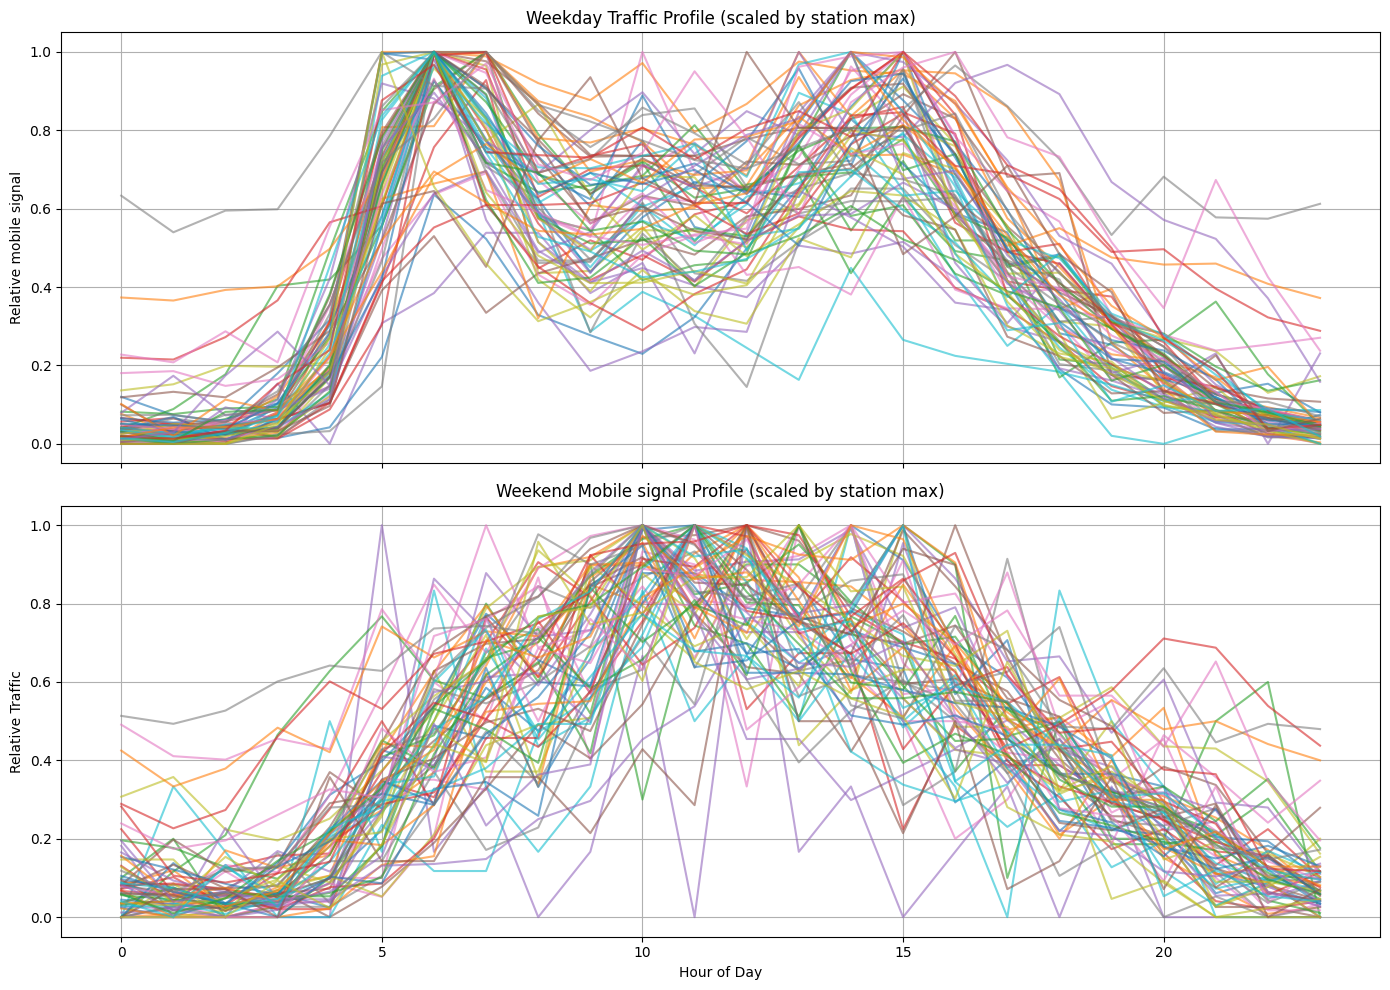

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
var = "signal_ctd_m_100_0"
# Convert date and add weekend indicator
df_all["dayofweek"] = pd.to_datetime(df_all["date"]).dt.dayofweek  # Monday = 0, Sunday = 6
df_all["is_weekend"] = df_all["dayofweek"] >= 5  # Saturday & Sunday

# Group and calculate mean traffic per hour per station
grouped_weekday = df_all[df_all["is_weekend"] == False].groupby(["h3res13", "hour"])[var].mean().reset_index()
grouped_weekend = df_all[df_all["is_weekend"] == True].groupby(["h3res13", "hour"])[var].mean().reset_index()

# Normalize traffic by mean per station (to compare relative patterns)
grouped_weekday["traffic_rel"] = grouped_weekday.groupby("h3res13")[var].transform(lambda x: x / x.max())
grouped_weekend["traffic_rel"] = grouped_weekend.groupby("h3res13")[var].transform(lambda x: x / x.max())

# Create vertically stacked plots
fig, axes = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

# Weekday plot
for h3_id in grouped_weekday["h3res13"].unique():
    subset = grouped_weekday[grouped_weekday["h3res13"] == h3_id]
    axes[0].plot(subset["hour"], subset["traffic_rel"], alpha=0.6, label=str(h3_id))
axes[0].set_title("Weekday Traffic Profile (scaled by station max)")
axes[0].set_ylabel("Relative mobile signal")
axes[0].grid(True)

# Weekend plot
for h3_id in grouped_weekend["h3res13"].unique():
    subset = grouped_weekend[grouped_weekend["h3res13"] == h3_id]
    axes[1].plot(subset["hour"], subset["traffic_rel"], alpha=0.6, label=str(h3_id))
axes[1].set_title("Weekend Mobile signal Profile (scaled by station max)")
axes[1].set_xlabel("Hour of Day")
axes[1].set_ylabel("Relative Traffic")
axes[1].grid(True)

plt.tight_layout()
plt.show()


In [5]:
import numpy as np
np.quantile(df_all["precipitation"], [0, 0.9, 0.95, 1])

array([0. , 0.1, 0.3, 6. ])

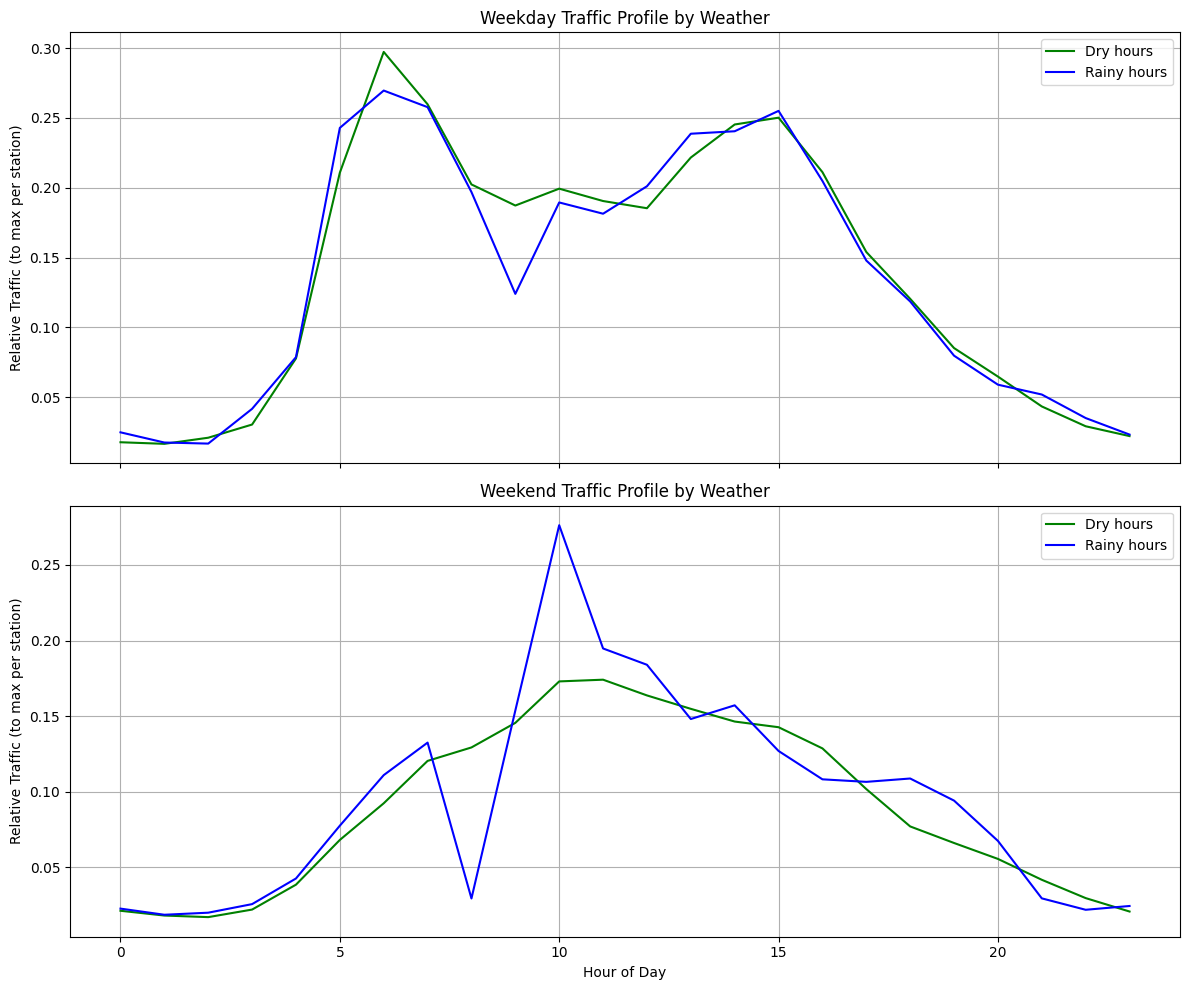

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

var = "signal_ctd_m_100_0"
precip_var = "precipitation"

# Ensure datetime and weekday/weekend classification
df_all["date"] = pd.to_datetime(df_all["date"])
df_all["dayofweek"] = df_all["date"].dt.dayofweek
df_all["is_weekend"] = df_all["dayofweek"] >= 5

# Scale by station max (over all days)
station_max = df_all.groupby("h3res13")[var].max().rename("max_value")
df_all = df_all.merge(station_max, on="h3res13")
df_all["signal_rel"] = df_all[var] / df_all["max_value"]

# Split into weekend and weekday
df_weekend = df_all[df_all["is_weekend"]]
df_weekday = df_all[~df_all["is_weekend"]]

# ---- WEEKDAY ----
weekday_rainy = df_weekday[df_weekday[precip_var] > 0.1]
weekday_dry = df_weekday[df_weekday[precip_var] <= 0.1]

weekday_rainy_avg = weekday_rainy.groupby("hour")["signal_rel"].mean().reset_index()
weekday_dry_avg = weekday_dry.groupby("hour")["signal_rel"].mean().reset_index()

# ---- WEEKEND ----
weekend_rainy = df_weekend[df_weekend[precip_var] > 0.1]
weekend_dry = df_weekend[df_weekend[precip_var] <= 0.1]

weekend_rainy_avg = weekend_rainy.groupby("hour")["signal_rel"].mean().reset_index()
weekend_dry_avg = weekend_dry.groupby("hour")["signal_rel"].mean().reset_index()

# ---- PLOT ----
fig, axes = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

# Weekday plot
axes[0].plot(weekday_dry_avg["hour"], weekday_dry_avg["signal_rel"], label="Dry hours", color="green")
axes[0].plot(weekday_rainy_avg["hour"], weekday_rainy_avg["signal_rel"], label="Rainy hours", color="blue")
axes[0].set_title("Weekday Traffic Profile by Weather")
axes[0].set_ylabel("Relative Traffic (to max per station)")
axes[0].legend()
axes[0].grid(True)

# Weekend plot
axes[1].plot(weekend_dry_avg["hour"], weekend_dry_avg["signal_rel"], label="Dry hours", color="green")
axes[1].plot(weekend_rainy_avg["hour"], weekend_rainy_avg["signal_rel"], label="Rainy hours", color="blue")
axes[1].set_title("Weekend Traffic Profile by Weather")
axes[1].set_xlabel("Hour of Day")
axes[1].set_ylabel("Relative Traffic (to max per station)")
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()


In [8]:
df_demo = df_all.groupby("h3res13")[["total0018_1", "total_1", "traffic"]].agg(["mean"])

In [9]:
df_all.filter(regex = "intensity|traffic").corr()["traffic"].sort_values()

roads_intensity_2_0_2   -0.246463
roads_intensity_2_0_1   -0.186994
roads_intensity_2_0_5   -0.099702
roads_intensity_2_1     -0.073924
roads_intensity_3_1      0.002742
roads_intensity_3_0_1    0.002887
roads_intensity_3_0_5    0.011798
roads_intensity_3_0_2    0.068640
roads_intensity_1_0_5    0.146096
roads_intensity_1_1      0.180162
roads_intensity_1_0_1    0.255311
roads_intensity_1_0_2    0.275364
traffic                  1.000000
Name: traffic, dtype: float64

In [10]:
df_all["intensive_traffic_road_ind"] = df_all["roads_intensity_1_0_1"]/df_all[["roads_intensity_1_0_1", "roads_intensity_2_0_1", "roads_intensity_3_0_1"]].sum(axis = 1)

In [11]:
df_roads = df_all.groupby("h3res13")[["intensive_traffic_road_ind", "traffic"]].agg("mean")

Text(0, 0.5, 'mean traffic')

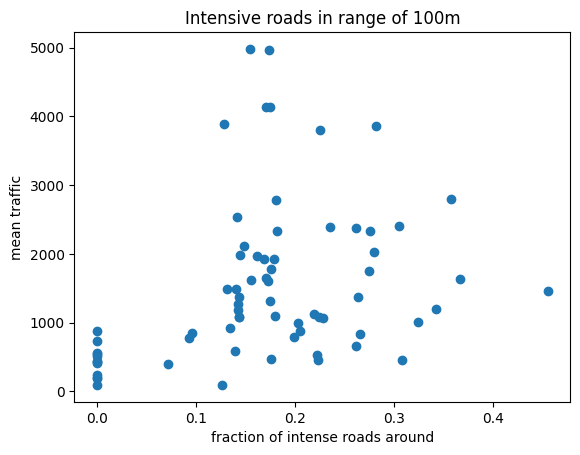

In [12]:
plt.scatter(df_roads["intensive_traffic_road_ind"], df_roads["traffic"])
plt.title("Intensive roads in range of 100m")
plt.xlabel("fraction of intense roads around")
plt.ylabel("mean traffic")

In [26]:
a = grouped_low.merge(df_all[["Residential_1", "Residential_0_5", "Residential_2", "h3res13"]], left_on = "h3res13", right_on = "h3res13", how = "left")

In [31]:
a.loc[a.hour == 12, ["Residential_1", "Residential_0_5", "Residential_2", "traffic_rel"]].corr()

Residential_1  Residential_0_5  Residential_2  traffic_rel
Residential_1         1.000000         0.847027       0.879849     0.247253
Residential_0_5       0.847027         1.000000       0.709998     0.168360
Residential_2         0.879849         0.709998       1.000000     0.377721
traffic_rel           0.247253         0.168360       0.377721     1.000000

In [34]:
np.quantile(a["Residential_2"], q = [0.5])

array([21550869.18])

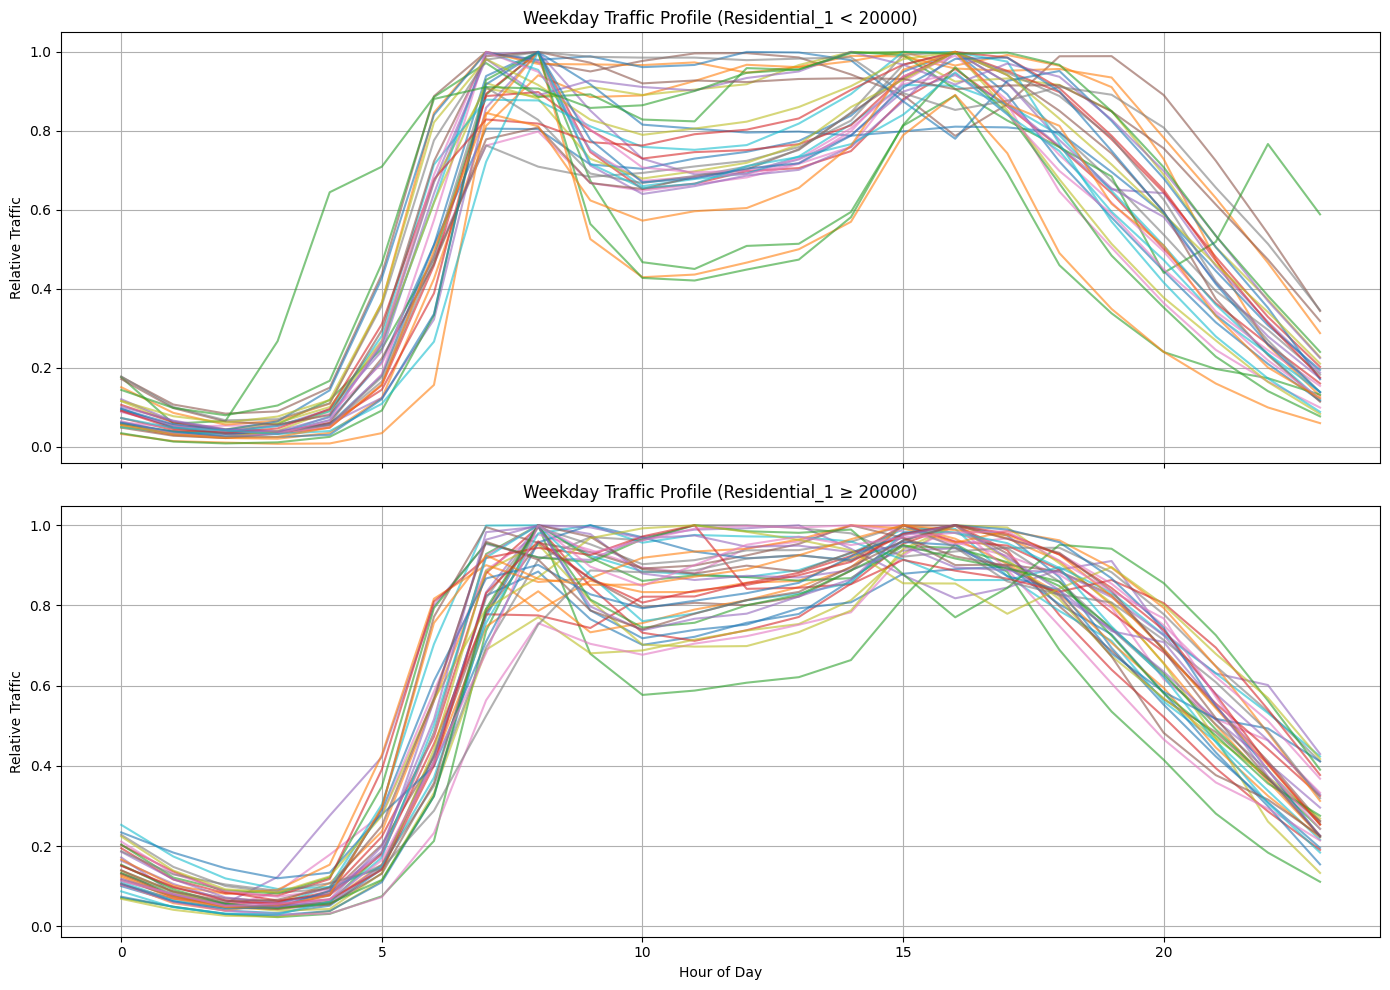

In [35]:
import pandas as pd
import matplotlib.pyplot as plt

# Convert 'date' to datetime and extract day of week (Monday = 0, Sunday = 6)
df_all["dayofweek"] = pd.to_datetime(df_all["date"]).dt.dayofweek

# Filter only weekdays (Monday to Friday)
df_weekdays = df_all[df_all["dayofweek"] < 5]

# Split the data based on Residential_1 threshold
df_low_res = df_weekdays[df_weekdays["Residential_2"] < 21 * 10 ** 6]
df_high_res = df_weekdays[df_weekdays["Residential_2"] >= 21 * 10 ** 6]

# Define a function to group and normalize traffic data
def group_and_normalize(df):
    grouped = df.groupby(["h3res13", "hour"])["traffic"].mean().reset_index()
    grouped["traffic_rel"] = grouped.groupby("h3res13")["traffic"].transform(lambda x: x / x.max())
    return grouped

# Apply function to each subset
grouped_low = group_and_normalize(df_low_res)
grouped_high = group_and_normalize(df_high_res)

# Create vertically stacked plots
fig, axes = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

# Plot for Residential_1 < 20000
for h3_id in grouped_low["h3res13"].unique():
    subset = grouped_low[grouped_low["h3res13"] == h3_id]
    axes[0].plot(subset["hour"], subset["traffic_rel"], alpha=0.6, label=str(h3_id))
axes[0].set_title("Weekday Traffic Profile (Residential_1 < 20000)")
axes[0].set_ylabel("Relative Traffic")
axes[0].grid(True)

# Plot for Residential_1 >= 20000
for h3_id in grouped_high["h3res13"].unique():
    subset = grouped_high[grouped_high["h3res13"] == h3_id]
    axes[1].plot(subset["hour"], subset["traffic_rel"], alpha=0.6, label=str(h3_id))
axes[1].set_title("Weekday Traffic Profile (Residential_1 ≥ 20000)")
axes[1].set_xlabel("Hour of Day")
axes[1].set_ylabel("Relative Traffic")
axes[1].grid(True)

plt.tight_layout()
plt.show()


In [46]:
np.quantile(df_weekdays["Residential_2"], [0.25, 0.5, 0.75])

array([15093699.25, 21550869.18, 27639288.15])

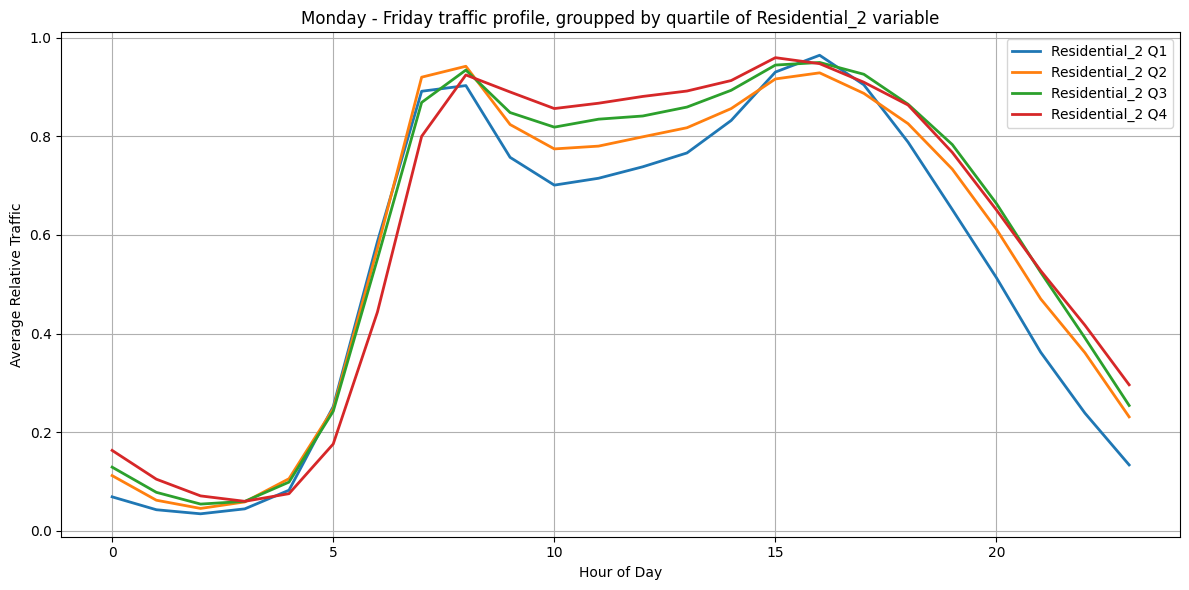

In [50]:
import pandas as pd
import matplotlib.pyplot as plt

# Convert 'date' to datetime and extract day of week (Monday = 0, Sunday = 6)
df_all["dayofweek"] = pd.to_datetime(df_all["date"]).dt.dayofweek

# Filter only weekdays (Monday to Friday)
df_weekdays = df_all[df_all["dayofweek"] < 5]

# Define Residential_1 groups
df_g1 = df_weekdays[df_weekdays["Residential_2"] < 15 * 10 ** 6]
df_g2 = df_weekdays[(df_weekdays["Residential_2"] >= 15 * 10 ** 6) & (df_weekdays["Residential_2"] < 21 * 10 ** 6)]
df_g3 = df_weekdays[(df_weekdays["Residential_2"] >= 21 * 10 ** 6) & (df_weekdays["Residential_2"] < 27 * 10 ** 6)]
df_g4 = df_weekdays[df_weekdays["Residential_2"] >= 27 * 10 ** 6]

# Function to normalize per station and average across all
def aggregate_normalized_profile(df):
    grouped = df.groupby(["h3res13", "hour"])["traffic"].mean().reset_index()
    grouped["traffic_rel"] = grouped.groupby("h3res13")["traffic"].transform(lambda x: x / x.max())
    avg_profile = grouped.groupby("hour")["traffic_rel"].mean().reset_index()
    return avg_profile

# Aggregate each group
g1_profile = aggregate_normalized_profile(df_g1)
g2_profile = aggregate_normalized_profile(df_g2)
g3_profile = aggregate_normalized_profile(df_g3)
g4_profile = aggregate_normalized_profile(df_g4)

# Plot all four curves
plt.figure(figsize=(12, 6))
plt.plot(g1_profile["hour"], g1_profile["traffic_rel"], label="Residential_2 Q1", linewidth=2)
plt.plot(g2_profile["hour"], g2_profile["traffic_rel"], label="Residential_2 Q2", linewidth=2)
plt.plot(g3_profile["hour"], g3_profile["traffic_rel"], label="Residential_2 Q3", linewidth=2)
plt.plot(g4_profile["hour"], g4_profile["traffic_rel"], label="Residential_2 Q4", linewidth=2)

plt.title("Monday - Friday traffic profile, groupped by quartile of Residential_2 variable")
plt.xlabel("Hour of Day")
plt.ylabel("Average Relative Traffic")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [55]:
df_all.filter(regex = "ctd")

signal_ctd_m_25_0  signal_ctd_m_50_0  signal_ctd_m_75_0  \
0                     0.0                0.0                0.0   
1                     0.0                0.0                0.0   
2                     0.0                0.0                0.0   
3                     0.0                0.0                0.0   
4                     1.0                2.0                2.0   
...                   ...                ...                ...   
102475                0.0                0.0                0.0   
102476                0.0                0.0                2.0   
102477                0.0                0.0                0.0   
102478                0.0                0.0                0.0   
102479                0.0                0.0                0.0   

        signal_ctd_m_100_0  signal_ctd_m_125_0  signal_ctd_m_250_0  \
0                      0.0                 0.0                 0.0   
1                      0.0                 0.0                 0.0   
2                      0.0                 0.0                 0.0   
3                      0.0                 0.0                 2.0   
4                      2.0                 6.0                13.0   
...                    ...                 ...                 ...   
102475                 0.0                 0.0                 0.0   
102476                 2.0                 2.0                 5.0   
102477                 0.0                 0.0                 0.0   
102478                 0.0                 0.0                 0.0   
102479                 0.0                 0.0                 3.0   

        signal_ctd_m_500_0  signal_ctd_rho_85  signal_ctd_rho_90  \
0                      1.0           2.043206           2.619597   
1                      0.0           1.373230           2.102954   
2                      1.0           2.352071           3.136842   
3                      6.0          10.902466          13.600186   
4                     19.0          25.697329          30.773259   
...                    ...                ...                ...   
102475                 5.0          24.118592          30.614628   
102476                15.0          23.835026          27.908631   
102477                 3.0           6.726251           8.720307   
102478                 2.0          11.925954          14.190121   
102479                 9.0           7.088572           7.889586   

        signal_ctd_rho_95  signal_ctd_rho_98  
0                3.411370           4.017333  
1                3.111037           3.874405  
2                4.158215           4.903986  
3               17.033790          19.506794  
4               37.439335          42.367990  
...                   ...                ...  
102475          38.454373          43.872044  
102476          32.761930          36.117179  
102477          11.192944          12.945150  
102478          16.683766          18.311772  
102479           8.803501           9.426730  

[102480 rows x 11 columns]

# INITIAL MODEL

In [107]:
df_all.to_parquet("df_modeling/df_modeling.parquet")

In [108]:
import statsmodels.api as sm
y_ = "traffic"
X_cols = ['intercept', 'home_service_5', 'structure_and_geography_10',
       'business_to_business_5', 'mass_media_10', 'hour',
       'roads_intensity_1_0.2', 'automotive_5', 'roads_intensity_2_0.2', 'pets_1',
       'total_0.5', 'female0018_0.5',
       'female1964_0.5', 'female6599_0.5']
reg = sm.OLS(df_all[y_], df_all[X_cols]).fit()

In [109]:
# df_all[['female0018_0.5', 'male0018_0.5', 'male6599_0.5',
#        'female1964_0.5', 'female6599_0.5']].corr()

In [110]:
reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                traffic   R-squared:                       0.360
Model:                            OLS   Adj. R-squared:                  0.359
Method:                 Least Squares   F-statistic:                     4362.
Date:                Sat, 12 Apr 2025   Prob (F-statistic):               0.00
Time:                        21:56:01   Log-Likelihood:            -8.6505e+05
No. Observations:              101016   AIC:                         1.730e+06
Df Residuals:                  101002   BIC:                         1.730e+06
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
intercept                    115.6898     32.109      3.603      0.000      52.756     178.623
home_service_5                 4.8908      0.130     37.721      0.000       4.637       5.145
structure_and_geography_10   -28.9411      0.513    -56.454      0.000     -29.946     -27.936
business_to_business_5        -1.9476      0.060    -32.622      0.000      -2.065      -1.831
mass_media_10                  3.6665      0.074     49.787      0.000       3.522       3.811
hour                          57.1554      0.576     99.229      0.000      56.026      58.284
roads_intensity_1_0.2       3949.7129     71.298     55.397      0.000    3809.969    4089.456
automotive_5                   4.3515      0.059     74.069      0.000       4.236       4.467
roads_intensity_2_0.2      -1668.9773     33.289    -50.136      0.000   -1734.223   -1603.731
pets_1                      -147.3719      1.562    -94.331      0.000    -150.434    -144.310
total_0.5                     -2.5442      0.062    -40.750      0.000      -2.667      -2.422
female0018_0.5                 3.0549      0.151     20.177      0.000       2.758       3.352
female1964_0.5                 5.5455      0.125     44.273      0.000       5.300       5.791
female6599_0.5                 3.8143      0.109     35.148      0.000       3.602       4.027
==============================================================================
Omnibus:                    11833.213   Durbin-Watson:                   0.132
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            17285.034
Skew:                           0.886   Prob(JB):                         0.00
Kurtosis:                       3.983   Cond. No.                     1.04e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.04e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [111]:
corr = df_all.corr()["traffic"].sort_values() # .index[0:10]

In [51]:
df_all

station_id       date         street                    segment  \
0            1366 2024-03-01  al. Krakowska  Hipotezy - granica miasta   
1            1366 2024-03-01  al. Krakowska  Hipotezy - granica miasta   
2            1366 2024-03-01  al. Krakowska  Hipotezy - granica miasta   
3            1366 2024-03-01  al. Krakowska  Hipotezy - granica miasta   
4            1366 2024-03-01  al. Krakowska  Hipotezy - granica miasta   
...           ...        ...            ...                        ...   
102475       1372 2024-04-30        Pułkowa    Dziwożony - Wóycickiego   
102476       1372 2024-04-30        Pułkowa    Dziwożony - Wóycickiego   
102477       1372 2024-04-30        Pułkowa    Dziwożony - Wóycickiego   
102478       1372 2024-04-30        Pułkowa    Dziwożony - Wóycickiego   
102479       1372 2024-04-30        Pułkowa    Dziwożony - Wóycickiego   

            lat      lon          h3res13  hour  traffic  Residential_0_2  \
0       52.1650  20.9321  8d1f5224541113f     0      246          9084.25   
1       52.1650  20.9321  8d1f5224541113f     1      124          9084.25   
2       52.1650  20.9321  8d1f5224541113f     2      137          9084.25   
3       52.1650  20.9321  8d1f5224541113f     3      157          9084.25   
4       52.1650  20.9321  8d1f5224541113f     4      300          9084.25   
...         ...      ...              ...   ...      ...              ...   
102475  52.3213  20.9132  8d1f53d9a592cbf    19     3740         28867.07   
102476  52.3213  20.9132  8d1f53d9a592cbf    20     3284         28867.07   
102477  52.3213  20.9132  8d1f53d9a592cbf    21     2509         28867.07   
102478  52.3213  20.9132  8d1f53d9a592cbf    22     1867         28867.07   
102479  52.3213  20.9132  8d1f53d9a592cbf    23     1092         28867.07   

        ...  is_holiday  dayofweek  weekedn      date_hour     date_station  \
0       ...           0          4        0   2024-03-01-0  2024-03-01-1366   
1       ...           0          4        0   2024-03-01-1  2024-03-01-1366   
2       ...           0          4        0   2024-03-01-2  2024-03-01-1366   
3       ...           0          4        0   2024-03-01-3  2024-03-01-1366   
4       ...           0          4        0   2024-03-01-4  2024-03-01-1366   
...     ...         ...        ...      ...            ...              ...   
102475  ...           0          1        0  2024-04-30-19  2024-04-30-1372   
102476  ...           0          1        0  2024-04-30-20  2024-04-30-1372   
102477  ...           0          1        0  2024-04-30-21  2024-04-30-1372   
102478  ...           0          1        0  2024-04-30-22  2024-04-30-1372   
102479  ...           0          1        0  2024-04-30-23  2024-04-30-1372   

        is_weekend  max_value  signal_rel  scaling_value  \
0            False       22.0    0.000000       5.803279   
1            False       22.0    0.000000       5.803279   
2            False       22.0    0.000000       5.803279   
3            False       22.0    0.000000       5.803279   
4            False       22.0    0.344633       5.803279   
...            ...        ...         ...            ...   
102475       False       17.0    0.000000       4.245902   
102476       False       17.0    0.471042       4.245902   
102477       False       17.0    0.000000       4.245902   
102478       False       17.0    0.000000       4.245902   
102479       False       17.0    0.000000       4.245902   

        intensive_traffic_road_ind  
0                         0.176136  
1                         0.176136  
2                         0.176136  
3                         0.176136  
4                         0.176136  
...                            ...  
102475                    0.305164  
102476                    0.305164  
102477                    0.305164  
102478                    0.305164  
102479                    0.305164  

[102480 rows x 373 columns]

In [80]:
corr.head(35)

roads_intensity_2_0.2                 -0.239573
relative_humidity_2m                  -0.206447
pets_wd0.8                            -0.182387
pets_wd1                              -0.180033
pets_0.5                              -0.159378
pets_wd0.6                            -0.156352
beauty_and_spa_wd0.2                  -0.156063
pets_1                                -0.151564
attractions_and_activities_wd0.2      -0.149992
male1964_0.5                          -0.149010
health_and_medical_wd0.2              -0.148202
accommodation_wd0.2                   -0.146192
total_0.5                             -0.144197
female0018_0.5                        -0.143557
male0018_0.5                          -0.141846
male6599_0.5                          -0.139483
female1964_0.5                        -0.138102
retail_wd0.4                          -0.137785
home_service_wd0.2                    -0.137756
attractions_and_activities_wd0.4      -0.129319
female6599_0.5                        -0

In [61]:
string_columns = df_all.select_dtypes(include=['object', 'string']).columns

In [62]:
string_columns

Index(['station_h3'], dtype='object')

In [82]:
poi = pd.read_parquet("dfs_processed/df_pois_agg.parquet")

(array([38., 13.,  7.,  6.,  0.,  0.,  3.,  0.,  0.,  2.]),
 array([ 0. ,  8.1, 16.2, 24.3, 32.4, 40.5, 48.6, 56.7, 64.8, 72.9, 81. ]),
 <BarContainer object of 10 artists>)

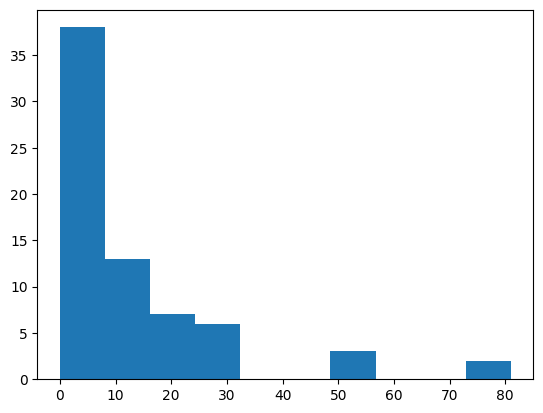

In [88]:
from matplotlib import pyplot as plt 
plt.hist(poi["active_life_0.5"])

In [79]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pydeck as pdk
import h3
from typing import Optional

def plot_h3_points_by_value(
    data: pd.DataFrame,
    h3_column_name: str = "h3res13",
    column: str = "col1",
    cmap: str = "YlOrRd",
    max_value: Optional[float] = None,
) -> pdk.Deck:
    assert h3_column_name in data.columns, f"Column '{h3_column_name}' not found."
    assert column in data.columns, f"Column '{column}' not found."
    
    df = data[[h3_column_name, column]].copy()

    # Convert H3 indexes to lat/lng
    df["lat"], df["lng"] = zip(*df[h3_column_name].map(h3.cell_to_latlng))

    # Normalize and apply colormap
    cmap_func = plt.get_cmap(cmap)
    scale_max = max_value or df[column].max()
    df["_value"] = np.minimum(1, df[column] / scale_max)
    df["_color"] = df["_value"].apply(lambda v: [int(c * 255) for c in cmap_func(v)[:3]])

    # Create a ScatterplotLayer
    layer = pdk.Layer(
        "ScatterplotLayer",
        df,
        get_position=["lng", "lat"],
        get_fill_color="_color",
        get_radius=80,
        pickable=True,
    )

    # Map view (centered on Warsaw)
    view_state = pdk.ViewState(latitude=52.237049, longitude=21.017532, zoom=11)

    tooltip = {"text": f"{column}: {{{column}}}"}

    return pdk.Deck(layers=[layer], initial_view_state=view_state, tooltip=tooltip)


In [58]:
df_sample = df_all[(df_all.hour == 12) & (df_all.date == "2024-03-15")]

In [61]:
df_sample.filter(regex = "ctd")

signal_ctd_m_25_0  signal_ctd_m_50_0  signal_ctd_m_75_0  \
348                   0.0                1.0                1.0   
1812                  0.0                2.0                7.0   
3276                  1.0                1.0                2.0   
4740                  0.0                2.0                4.0   
6204                  0.0                0.0                0.0   
...                   ...                ...                ...   
95508                 0.0                0.0                1.0   
96972                 0.0                1.0                1.0   
98436                 0.0                0.0                3.0   
99900                 0.0                3.0                3.0   
101364                0.0                0.0                0.0   

        signal_ctd_m_100_0  signal_ctd_m_125_0  signal_ctd_m_250_0  \
348                    1.0                 3.0                27.0   
1812                  22.0                27.0                88.0   
3276                   3.0                 6.0                14.0   
4740                   8.0                 9.0                21.0   
6204                   0.0                 2.0                26.0   
...                    ...                 ...                 ...   
95508                  1.0                 1.0                43.0   
96972                  1.0                 3.0               136.0   
98436                 21.0                40.0                91.0   
99900                  3.0                 4.0                10.0   
101364                 1.0                 3.0                11.0   

        signal_ctd_m_500_0  signal_ctd_rho_85  signal_ctd_rho_90  \
348                   59.0          85.359167         104.147484   
1812                 231.0         347.251892         402.340698   
3276                  42.0         124.491125         167.744182   
4740                 145.0         351.816031         423.038660   
6204                  37.0         141.914148         178.337173   
...                    ...                ...                ...   
95508                171.0         487.371634         582.392954   
96972                334.0         530.966715         617.687489   
98436                230.0         487.127227         582.332718   
99900                123.0         222.886949         267.482217   
101364                13.0          58.804207          73.968066   

        signal_ctd_rho_95  signal_ctd_rho_98  
348            128.361114         146.048853  
1812           463.722727         503.817462  
3276           221.859234         259.982509  
4740           502.875303         555.077390  
6204           221.777332         251.577656  
...                   ...                ...  
95508          689.030448         759.006096  
96972          714.990353         778.941905  
98436          690.169995         761.290809  
99900          319.237382         354.040265  
101364          92.129741         104.641199  

[70 rows x 11 columns]

In [77]:
import numpy as np
import pandas as pd
import pydeck as pdk
import matplotlib.pyplot as plt
import h3  # Make sure h3-py v4+
from typing import Optional

def plot_h3_points(
    data: pd.DataFrame,
    h3_column_name: str = "h3res13",
    column: str = "feat",
    size_column: str = "feat2",
    cmap: str = "coolwarm"
) -> pdk.Deck:
    assert h3_column_name in data.columns, f"Column '{h3_column_name}' not in DataFrame"
    assert column in data.columns, f"Column '{column}' not in DataFrame"
    assert size_column in data.columns, f"Size column '{size_column}' not in DataFrame"

    df = data[[h3_column_name, column, size_column]].copy()

    # Convert H3 index to (lat, lon)
    df[["lat", "lon"]] = df[h3_column_name].apply(lambda x: pd.Series(h3.cell_to_latlng(x)))

    # Normalize color values (from 'column') and cap at 1
    values = df[column]
    max_val = values.max()
    min_val = values.min()
    denom = 0.5 * (max_val - min_val + 1e-9)
    norm_color = ((values - min_val) / denom).clip(upper=1)

    cmap_func = plt.get_cmap(cmap)
    df["color"] = norm_color.apply(lambda v: [int(c * 255) for c in cmap_func(v)[:3]])

    # Normalize size values (from 'size_column') and scale to radius range
    size_vals = df[size_column]
    size_min, size_max = size_vals.min(), size_vals.max()
    norm_size = ((size_vals - size_min) / (size_max - size_min + 1e-9)).clip(0, 1)
    df["radius"] = norm_size * 300 + 100  # radius between 30 and 330

    # Create ScatterplotLayer
    layer = pdk.Layer(
        "ScatterplotLayer",
        df,
        get_position="[lon, lat]",
        get_radius="radius",
        get_fill_color="color",
        pickable=True,
        auto_highlight=True,
    )

    # View centered on Warsaw
    view_state = pdk.ViewState(latitude=52.237049, longitude=21.017532, zoom=11)

    tooltip = {"text": f"{column}: {{{column}}}\n{size_column}: {{{size_column}}}"}
    return pdk.Deck(layers=[layer], initial_view_state=view_state, tooltip=tooltip)


In [78]:
plot_h3_points(df_sample, column = "traffic", size_column = "signal_ctd_m_100_0")

{
  "initialViewState": {
    "latitude": 52.237049,
    "longitude": 21.017532,
    "zoom": 11
  },
  "layers": [
    {
      "@@type": "ScatterplotLayer",
      "autoHighlight": true,
      "data": [
        {
          "color": [
            235,
            127,
            99
          ],
          "h3res13": "8d1f5224541113f",
          "lat": 52.16498661160792,
          "lon": 20.932116386618276,
          "radius": 105.08474576262569,
          "signal_ctd_m_100_0": 1.0,
          "traffic": 3132
        },
        {
          "color": [
            170,
            198,
            253
          ],
          "h3res13": "8d1f52248b302ff",
          "lat": 52.14317928530904,
          "lon": 21.020293710935857,
          "radius": 211.864406777765,
          "signal_ctd_m_100_0": 22.0,
          "traffic": 1362
        },
        {
          "color": [
            104,
            137,
            238
          ],
          "h3res13": "8d1f5224c89b23f",
          "lat": 52.15649944549244,
          "lon": 20.992538683741348,
          "radius": 115.25423728787705,
          "signal_ctd_m_100_0": 3.0,
          "traffic": 665
        },
        {
          "color": [
            164,
            194,
            254
          ],
          "h3res13": "8d1f5224dcdd63f",
          "lat": 52.152014309397416,
          "lon": 21.022919797457902,
          "radius": 140.67796610100547,
          "signal_ctd_m_100_0": 8.0,
          "traffic": 1308
        },
        {
          "color": [
            220,
            220,
            221
          ],
          "h3res13": "8d1f52260d8eaff",
          "lat": 52.20777658927676,
          "lon": 20.892183187060443,
          "radius": 100.0,
          "signal_ctd_m_100_0": 0.0,
          "traffic": 1981
        },
        {
          "color": [
            179,
            3,
            38
          ],
          "h3res13": "8d1f5226110b2bf",
          "lat": 52.20711352975249,
          "lon": 20.94449916840433,
          "radius": 369.4915254191612,
          "signal_ctd_m_100_0": 53.0,
          "traffic": 7061
        },
        {
          "color": [
            216,
            219,
            225
          ],
          "h3res13": "8d1f522644a657f",
          "lat": 52.2166021583234,
          "lon": 20.87704991578955,
          "radius": 105.08474576262569,
          "signal_ctd_m_100_0": 1.0,
          "traffic": 1923
        },
        {
          "color": [
            247,
            178,
            149
          ],
          "h3res13": "8d1f5226519acff",
          "lat": 52.22150333057705,
          "lon": 20.9218739645706,
          "radius": 100.0,
          "signal_ctd_m_100_0": 0.0,
          "traffic": 2658
        },
        {
          "color": [
            198,
            214,
            241
          ],
          "h3res13": "8d1f522654811bf",
          "lat": 52.215481901710724,
          "lon": 20.914803637233625,
          "radius": 110.16949152525136,
          "signal_ctd_m_100_0": 2.0,
          "traffic": 1693
        },
        {
          "color": [
            162,
            192,
            254
          ],
          "h3res13": "8d1f522661aca7f",
          "lat": 52.20682197964051,
          "lon": 20.869121637446625,
          "radius": 100.0,
          "signal_ctd_m_100_0": 0.0,
          "traffic": 1281
        },
        {
          "color": [
            138,
            173,
            253
          ],
          "h3res13": "8d1f522696d177f",
          "lat": 52.176908984364914,
          "lon": 21.037806465720756,
          "radius": 161.0169491515082,
          "signal_ctd_m_100_0": 12.0,
          "traffic": 1027
        },
        {
          "color": [
            187,
            26,
            43
          ],
          "h3res13": "8d1f52269a55dbf",
          "lat": 52.19231363483802,
          "lon": 21.047797611035538,
          "radius": 399.99999999491524,
          "signal_ctd_m_100_0": 59.0,
          "traffic": 3763
     